In [1]:
!pip install toolz tqdm


### Prototypical Networks

This notebook is based on [abdulfatir/prototypical-networks-tensorflow](https://github.com/abdulfatir/prototypical-networks-tensorflow/blob/master/ProtoNet-Omniglot.ipynb)

What is added

* Dropout
* Adaptive learning rate

I also cleaned the code somewhat and added plot of training accuracy and loss.


In [0]:
%matplotlib inline
from __future__ import print_function
from PIL import Image
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
PICKLE_IDS = ["1Lv8Z8h6DWySrzAWBbeymk2klCh8cknC_", "10CjCaWzytsd8PE_4rHo3Y2vTCjPCWEyd"]
FILE_NAMES = ["train.pkl", "test.pkl"]

### Data loading

In [0]:
from toolz import compose
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle


"""
  Load (pickled) data files from Google Drive
"""

auth.authenticate_user()
drive_service = build('drive', 'v3')


def create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def download_file_bytes(request):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      # _ is a placeholder for a progress object that we ignore.
      # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)
    return downloaded.read()


def save_to_vm_drive(file_bytes, save_to):
    with open(save_to, "wb") as f:
        f.write(file_bytes)


def load_from_vm_drive(load_from):
    return pickle.load(open(load_from, "rb"))


def save_data(file_ids, file_dests):
    for file_id, dest in zip(file_ids, file_dests):
        file_bytes = compose(download_file_bytes, create_file_request)(file_id)
        save_to_vm_drive(file_bytes, dest)


def load_data(file_dests):
    for dest in file_dests:
        yield load_from_vm_drive(dest)

### Layer definitions

In [0]:
def conv_block(inputs, out_channels, training, rate, name='conv'):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
        conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
        conv = tf.nn.relu(conv)
        conv = tf.contrib.layers.max_pool2d(conv, 2)
        conv = tf.layers.dropout(conv, rate=rate, training=training)
        return conv

      
def encoder(x, h_dim, z_dim, training, rate, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        net = conv_block(x, h_dim, name='conv_1', training=training, rate=rate)
        net = conv_block(net, h_dim, name='conv_2', training=training, rate=rate)
        net = conv_block(net, h_dim, name='conv_3', training=training, rate=rate)
        net = conv_block(net, z_dim, name='conv_4', training=training, rate=rate)
        net = tf.contrib.layers.flatten(net)
        return net

      
def euclidean_distance(a, b):
    # a.shape = N x D
    # b.shape = M x D
    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)
  
  
def setup_inputs(im_height, im_width, channels):
    x = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
    q = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
    y = tf.placeholder(tf.int64, [None, None])
    training = tf.placeholder(tf.bool)
    return x, q, y, training


def setup_outputs(x, q, y, training, h_dim, z_dim, channels, dropout_rate):
    x_shape = tf.shape(x)
    q_shape = tf.shape(q)

    num_classes, num_support = x_shape[0], x_shape[1]
    num_queries = q_shape[1]
    im_height = x_shape[2]
    im_width = x_shape[3]

    y_one_hot = tf.one_hot(y, depth=num_classes)

    emb_x = encoder(tf.reshape(x, [num_classes * num_support, im_height, im_width, channels]), h_dim, z_dim, training=training, rate=dropout_rate)
    emb_dim = tf.shape(emb_x)[-1]
    emb_x = tf.reduce_mean(tf.reshape(emb_x, [num_classes, num_support, emb_dim]), axis=1)
    emb_q = encoder(tf.reshape(q, [num_classes * num_queries, im_height, im_width, channels]), h_dim, z_dim, reuse=True, training=training, rate=dropout_rate)

    dists = euclidean_distance(emb_q, emb_x)
    log_p_y = tf.reshape(tf.nn.log_softmax(-dists), [num_classes, num_queries, -1])

    ce_loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, log_p_y), axis=-1), [-1]))
    acc = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(log_p_y, axis=-1), y)))
    return ce_loss, acc


def setup_train_op(
        starter_learning_rate=0.002,
        decay_rate=0.5,
        epoch_decay_interval=20,
        n_episodes=100):
    """
      Defaults are set according to original paper
    """


    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.002
    learning_rate = tf.train.exponential_decay(
      starter_learning_rate,
      global_step,
      epoch_decay_interval * n_episodes,
      decay_rate,
      staircase=True
    )

    return (
        tf.train.AdamOptimizer(learning_rate)
          .minimize(ce_loss, global_step=global_step)
    )

### Load train and test datasets

In [6]:
# save_data(PICKLE_IDS, FILE_NAMES)
train_dataset, test_dataset = list(load_data(FILE_NAMES))

print("train dataset shape:", train_dataset.shape)
print("test dataset shape:", test_dataset.shape)

train dataset shape: (4112, 20, 28, 28)
test dataset shape: (1692, 20, 28, 28)


### Hyperparameters

In [0]:
n_classes, n_examples, im_width, im_height = train_dataset.shape

n_epochs = 30
n_episodes = 100
n_way = 60
n_shot = 8
n_query = 8
channels = 1
h_dim = 64
z_dim = 64
dropout_rate=0.1

### Define network

In [0]:
x, q, y, training = setup_inputs(im_height, im_width, channels)

ce_loss, acc = setup_outputs(x, q, y, training, h_dim, z_dim, channels, dropout_rate)

train_op = setup_train_op(
    epoch_decay_interval=20,
    n_episodes=n_episodes)

### Initialize session

In [0]:
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)

### Train network

In [0]:
train_losses = []
train_accs = []

In [11]:
%%time

for ep in range(n_epochs):
    for epi in tqdm(range(n_episodes), desc='episode'):
        epi_classes = np.random.permutation(n_classes)[:n_way]
        support = np.zeros([n_way, n_shot, im_height, im_width], dtype=np.float32)
        query = np.zeros([n_way, n_query, im_height, im_width], dtype=np.float32)
        
        for i, epi_cls in enumerate(epi_classes):
            selected = np.random.permutation(n_examples)[:n_shot + n_query]
            support[i] = train_dataset[epi_cls, selected[:n_shot]]
            query[i] = train_dataset[epi_cls, selected[n_shot:]]
        
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_way)[:, np.newaxis], (1, n_query)).astype(np.uint8)
        _, ls, ac = sess.run([train_op, ce_loss, acc], feed_dict={x: support, q: query, y:labels, training: True})
        train_losses.append(ls)
        train_accs.append(ac)
    print('[epoch {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(ep+1, n_epochs, ls, ac))

episode:   1%|          | 1/100 [00:00<00:16,  5.90it/s]

[epoch 1/30] => loss: 1.49634, acc: 0.71875


episode:   1%|          | 1/100 [00:00<00:16,  5.86it/s]

[epoch 2/30] => loss: 0.73625, acc: 0.85417


episode:   1%|          | 1/100 [00:00<00:17,  5.73it/s]

[epoch 3/30] => loss: 0.41844, acc: 0.89167


episode:   1%|          | 1/100 [00:00<00:17,  5.73it/s]

[epoch 4/30] => loss: 0.30893, acc: 0.92292


episode:   1%|          | 1/100 [00:00<00:16,  5.88it/s]

[epoch 5/30] => loss: 0.27343, acc: 0.93750


episode:   1%|          | 1/100 [00:00<00:16,  5.89it/s]

[epoch 6/30] => loss: 0.22506, acc: 0.93542


episode:   1%|          | 1/100 [00:00<00:17,  5.73it/s]

[epoch 7/30] => loss: 0.19418, acc: 0.93750


episode:   1%|          | 1/100 [00:00<00:17,  5.74it/s]

[epoch 8/30] => loss: 0.12999, acc: 0.96250


episode:   1%|          | 1/100 [00:00<00:16,  5.88it/s]

[epoch 9/30] => loss: 0.19744, acc: 0.95208


episode:   1%|          | 1/100 [00:00<00:16,  5.87it/s]

[epoch 10/30] => loss: 0.21739, acc: 0.94583


episode:   1%|          | 1/100 [00:00<00:16,  5.84it/s]

[epoch 11/30] => loss: 0.17447, acc: 0.96458


episode:   1%|          | 1/100 [00:00<00:17,  5.77it/s]

[epoch 12/30] => loss: 0.15571, acc: 0.95625


episode:   1%|          | 1/100 [00:00<00:17,  5.75it/s]

[epoch 13/30] => loss: 0.12801, acc: 0.95833


episode:   1%|          | 1/100 [00:00<00:16,  5.91it/s]

[epoch 14/30] => loss: 0.15905, acc: 0.96458


episode:   1%|          | 1/100 [00:00<00:16,  5.83it/s]

[epoch 15/30] => loss: 0.14636, acc: 0.97083


episode:   1%|          | 1/100 [00:00<00:17,  5.75it/s]

[epoch 16/30] => loss: 0.12126, acc: 0.96250


episode:   1%|          | 1/100 [00:00<00:17,  5.78it/s]

[epoch 17/30] => loss: 0.13283, acc: 0.96042


episode:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

[epoch 18/30] => loss: 0.08322, acc: 0.97708


episode:   1%|          | 1/100 [00:00<00:17,  5.80it/s]

[epoch 19/30] => loss: 0.14882, acc: 0.94375


episode:   1%|          | 1/100 [00:00<00:17,  5.72it/s]

[epoch 20/30] => loss: 0.12388, acc: 0.96667


episode:   1%|          | 1/100 [00:00<00:17,  5.72it/s]

[epoch 21/30] => loss: 0.13506, acc: 0.95833


episode:   1%|          | 1/100 [00:00<00:17,  5.78it/s]

[epoch 22/30] => loss: 0.09244, acc: 0.97292


episode:   1%|          | 1/100 [00:00<00:17,  5.80it/s]

[epoch 23/30] => loss: 0.11163, acc: 0.96042


episode:   1%|          | 1/100 [00:00<00:17,  5.76it/s]

[epoch 24/30] => loss: 0.22730, acc: 0.92292


episode:   1%|          | 1/100 [00:00<00:16,  5.89it/s]

[epoch 25/30] => loss: 0.06508, acc: 0.97917


episode:   1%|          | 1/100 [00:00<00:16,  5.89it/s]

[epoch 26/30] => loss: 0.16166, acc: 0.94583


episode:   1%|          | 1/100 [00:00<00:17,  5.82it/s]

[epoch 27/30] => loss: 0.09241, acc: 0.97292


episode:   1%|          | 1/100 [00:00<00:16,  5.91it/s]

[epoch 28/30] => loss: 0.10521, acc: 0.96875


episode:   1%|          | 1/100 [00:00<00:17,  5.68it/s]

[epoch 29/30] => loss: 0.08369, acc: 0.97500


episode: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]

[epoch 30/30] => loss: 0.10047, acc: 0.96667
CPU times: user 4min 36s, sys: 2min 24s, total: 7min
Wall time: 8min 38s


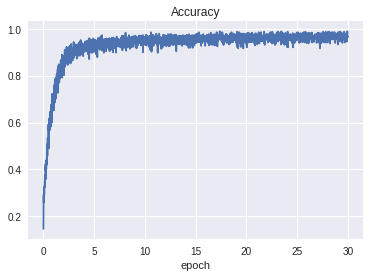

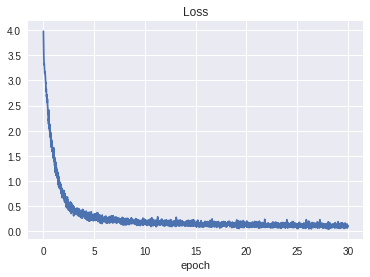

In [12]:
for name, metric in zip(["Accuracy", "Loss"], [train_accs, train_losses]):
  plt.plot(metric)
  plt.title(name)
  plt.xticks(range(0, n_epochs * n_episodes + 1, n_episodes * 5), range(0, n_epochs + 1, 5))
  plt.xlabel("epoch")
  plt.show()

In [0]:
n_test_classes = test_dataset.shape[0]
n_test_episodes = 100
n_test_way = 20
n_test_shot = 5
n_test_query = 15

In [14]:
print('Testing...')
avg_acc = 0.

for epi in range(n_test_episodes):
    epi_classes = np.random.permutation(n_test_classes)[:n_test_way]
    support = np.zeros([n_test_way, n_test_shot, im_height, im_width], dtype=np.float32)
    query = np.zeros([n_test_way, n_test_query, im_height, im_width], dtype=np.float32)
    
    for i, epi_cls in enumerate(epi_classes):
        selected = np.random.permutation(n_examples)[:n_test_shot + n_test_query]
        support[i] = test_dataset[epi_cls, selected[:n_test_shot]]
        query[i] = test_dataset[epi_cls, selected[n_test_shot:]]
    support = np.expand_dims(support, axis=-1)
    query = np.expand_dims(query, axis=-1)
    labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
    ls, ac = sess.run([ce_loss, acc], feed_dict={x: support, q: query, y:labels, training:False})
    avg_acc += ac
    
    if (epi+1) % 25 == 0:
        print('[test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_test_episodes, ls, ac))

avg_acc /= n_test_episodes
print('Average Test Accuracy: {:.5f}'.format(avg_acc))

Testing...
[test episode 25/100] => loss: 0.01606, acc: 0.99667
[test episode 50/100] => loss: 0.05649, acc: 0.99000
[test episode 75/100] => loss: 0.04186, acc: 0.98667
[test episode 100/100] => loss: 0.08889, acc: 0.98667
Average Test Accuracy: 0.98610
